In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
import tensorflow as tf


# EDA

In [ ]:
train_dir= '/content/drive/MyDrive/extracted_faces/train'
test_dir= '/content/drive/MyDrive/extracted_faces/test'
val_dir= '/content/drive/MyDrive/extracted_faces/validation'

In [ ]:
def explore_dataset(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

print("Train Dataset:", explore_dataset(train_dir))
print("Test Dataset:", explore_dataset(test_dir))
print("Test Dataset:", explore_dataset(val_dir))

Train Dataset: {'Square': 798, 'Oval': 800, 'Heart': 799, 'Round': 800, 'Oblong': 809}
Test Dataset: {'Oblong': 100, 'Square': 100, 'Oval': 100, 'Heart': 105, 'Round': 100}
Test Dataset: {'Oblong': 100, 'Square': 100, 'Oval': 100, 'Heart': 105, 'Round': 100}


# Image Prepocessing

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 50

In [ ]:
classes = [class_name for class_name in os.listdir(train_dir)]
def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [ ]:
train_df = create_df(train_dir)
test_df = create_df(test_dir)
val_df = create_df(val_dir)

In [ ]:
# 2. Image Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4006 validated image filenames belonging to 5 classes.
Found 505 validated image filenames belonging to 5 classes.
Found 505 validated image filenames belonging to 5 classes.


# Modelling

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(5, activation="softmax")
])



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 23,797,509 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.90:
            self.model.stop_training = True
            print("\nReached 90% accuracy so cancelling training!")

early_stopping_callback = EarlyStoppingCallback()

# Train Model

In [ ]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
    # callbacks=[early_stopping_callback]
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 1611s 12s/step - accuracy: 0.4459 - loss: 1.4197 - val_accuracy: 0.1980 - val_loss: 2.8998
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 38s 296ms/step - accuracy: 0.8550 - loss: 0.4315 - val_accuracy: 0.1980 - val_loss: 1.9749
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - accuracy: 0.9238 - loss: 0.2103 - val_accuracy: 0.2040 - val_loss: 2.2542
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.9607 - loss: 0.1206 - val_accuracy: 0.2317 - val_loss: 2.1744
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 301ms/step - accuracy: 0.9609 - loss: 0.1168 - val_accuracy: 0.2277 - val_loss: 2.1495
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 305ms/step - accuracy: 0.9672 - loss: 0.0950 - val_accuracy: 0.2396 - val_loss: 3.5278
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 326ms/step - accuracy: 0.9623 - loss: 0.1281 - val_accuracy: 0.3564 - val_loss: 3.9478
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - accuracy: 0.9856 - loss: 0.0532 - val

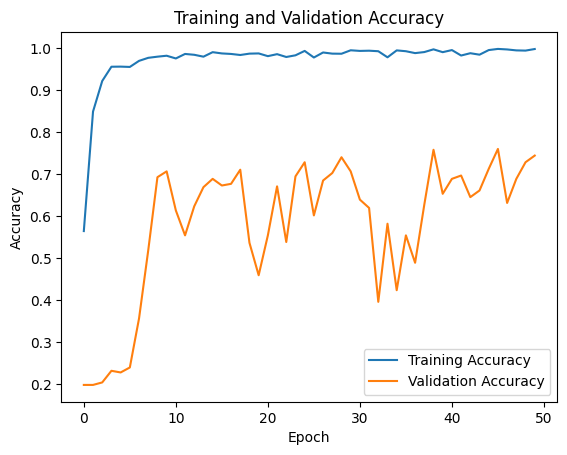

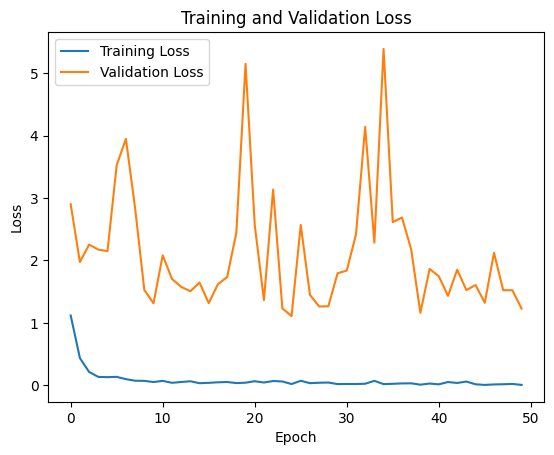

In [ ]:
# Visualisasi akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 174s 12s/step - accuracy: 0.7183 - loss: 1.5669

Test Accuracy: 77.03%


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 342ms/step


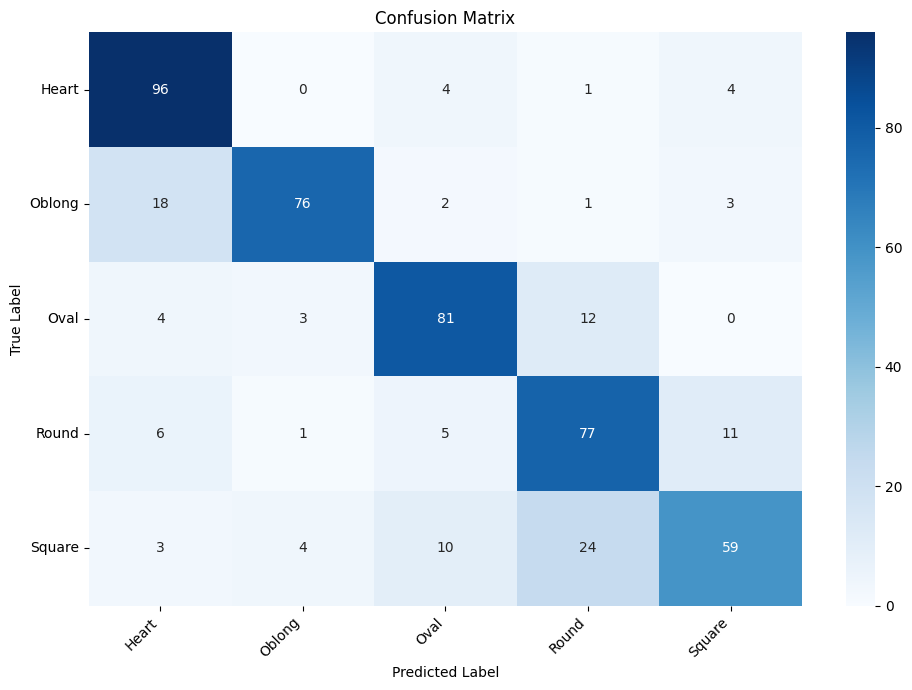

In [ ]:
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

# Visualisasikan confusion matrix menggunakan seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
model.save('model_face_shape_V2.h5')

In [ ]:
model = tf.keras.models.load_model('model_face_shape_V2.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()


with open('model_face_shape_V2.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmptfubo7wq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134560945359504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134560945364432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134560945372528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134560945372000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134560945368656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134560945370944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134560945357568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134560945392448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134560945392096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134560945393856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1345609453899